In [1]:
# import logging
import os
import re
from pathlib import Path
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import torch
import yaml
from einops import rearrange

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
from mushroom.mushroom import Mushroom
import mushroom.data.xenium as xenium
import mushroom.data.visium as visium
import mushroom.utils as utils
import mushroom.visualization.utils as vis_utils

/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/spatialdata/__init__.py:9: UserWarning: Geopandas was set to use PyGEOS, changing to shapely 2.0 with:

	geopandas.options.use_pygeos = True

If you intended to use PyGEOS, set the option to False.
  _check_geopandas_using_shapely()


In [5]:
run_dir = '/data/estorrs/mushroom/data/projects/xenium_grant'
mushroom_dir = os.path.join(run_dir, 'mushroom')
config_fps = sorted(utils.listfiles(mushroom_dir, regex=r'/config.yaml'))
config_fps

['/data/estorrs/mushroom/data/projects/xenium_grant/mushroom/HT206B1/config.yaml',
 '/data/estorrs/mushroom/data/projects/xenium_grant/mushroom/S18-25943/config.yaml',
 '/data/estorrs/mushroom/data/projects/xenium_grant/mushroom/S18-9906/config.yaml']

In [6]:
# only relavent for dinglab data since our channel names are all over the place
# will remove for official example
official_to_options = {
    'Pan-Cytokeratin': ['Pan-Cytokeratin', 'Pan-CK', 'Pan-CK (D)', 'PanCK (D)'],
    'E-cadherin': ['E-cadherin'],
    'CD45': ['CD45 (D)', 'CD45', 'CD45-(D)', 'CD45(D)'],
    'CD45RO': ['CD45RO'],
    'CD45RA': ['CD45RA'],
    'CD8': ['CD8', 'CD8a'],
    'DAPI': ['DAPI'],
    'CD4': ['CD4', 'CD4 (D)'],
    'CD3e': ['CD3e', 'CD3'],
    'Vimentin': ['Vimentin-(D)', 'Vimentin', 'Vimentin (D)'],
    'SMA': ['SMA-(D)', 'SMA', 'SMA (D)', 'a-SMA (D)'],
    'CD31': ['CD31', 'CD31-(D)', 'CD31 (D)'],
    'CD20': ['CD20-(D)', 'CD20', 'CD20 (D)', 'CD20-Akoya'],
    'CD68': ['CD68', 'CD68 (D)', 'CD68-(D)'],
    'CD163': ['CD163'],
    'FOXP3': ['FoxP3', 'FOXP3', 'Foxp3'],
    'cKit': ['cKIT (D)', 'cKit (D)', 'cKit', 'cKIT', 'cKIT-(D)'],
    'MGP': ['MGP', 'MGP (D)', 'MGP-(D)'],
    'CD36': ['CD36-(D)', 'CD36'],
    'PR': ['PR', 'PR-(D)', 'PR (D)'],
    'ER': ['ER', 'ER-(D)', 'ER (D)'],
    'P21': ['P21', 'P21-(D)', 'P21-(D)', 'P21 (D)'],
    'P16': ['P16-(D)'],
    'CK5': ['Keratin 5', 'KRT5'],
    'TFF1': ['TFF1', 'TFF1-(D)', 'TFF1 (D)'],
    'beta-integrin': ['beta-integrin', 'beta3-integrin'],
    'CK14': ['CK14', 'Keratin 14', 'CK14 (D)'],
    'CK17': ['CK17', 'CK17 (D)', 'CK17-(D)', 'Keratin 17'],
    'CK19': ['CK19', 'CK19 (D)', 'CK19-(D)'],
    'CD11b': ['CD11b', 'CD11b (D)', 'CD11b-(D)'],
    'GATA3': ['GATA3', 'GATA3-(D)', 'GATA3 (D)'],
    'PLAT/tPA': ['PLAT/tPA', 'PLAT/tPA (D)'],
    'COX6c': ['COX6c (D)'],
    'Her2': ['Her2', 'Her2 (D)'],
    'Bap1': ['Bap1 (D)'],
    'GLUT1': ['Glut1', 'GLUT1', 'GLUT1-(D)', 'GLUT1 (D)'],
    'CD11c': ['CD11c'],
    'HLA-DR': ['HLA-DR'],
    'Ki67': ['Ki67', 'KI67'],
    'Podoplanin': ['Podoplanin', 'PDPN', 'Podoplanin (D)'],
    'CTLA4': ['CTLA4', 'CTLA4 (D)', 'CTLA4-(D)'],
    'SLC39A6': ['SLC39A6'],
    'BCA1': ['BCA1'],
    'BCAL': ['BCAL'],
    'TUBB3': ['TUBB3', 'TUBB3 (D)'],
    'PTPRZ1': ['PTPRZ1', 'PTPRZ1 (D)'],
    'HIF1A': ['HIF1a', 'HIF1a (D)', 'HIF1A'],
    'PAI1': ['PAI1', 'PAI1-(D)'],
    'GFAP': ['GFAP', 'GFAP (D)'],
    'VEGFA': ['VEGFA', 'VEGFA (D)'],
    'IBA1': ['IBA1', 'IBA1 (D)'],
    'OLIG2': ['OLIG2', 'OLIG2 (D)'],
    'FN1': ['FN1', 'FN1 (D)'],
    'a-Amylase': ['a-Amylase'],
    'Hep-Par-1': ['Hep-Par-1 (D)'],
    'Granzyme-B': ['Granzyme B'],
    'TCF-1': ['TCF-1'],
    'CD39': ['CD39'],
    'PD1': ['PD-1'],
    'PDL1': ['PD-L1'],
    'Histone-H3-Pho': ['Histone H3 Pho'],
    'Maspin': ['Maspin'],
    'MMP9': ['MMP9'],
    'CD44': ['CD44'],
    'CD107A': ['CD107a'],
    'FGFR3': ['FGFR3'],
    'CD138': ['CD138'],
    'MLPH': ['MLPH'],
    'P63': ['P63'],
    'GP2': ['GP2'],
    'COX2': ['COX2'],
    'Lyve-1': ['Lyve-1'],
}
channel_mapping = {v:k for k, vs in official_to_options.items() for v in vs}
# channel_mapping = None

In [7]:
mushroom_config = {
    'dtype': 'multiplex',
#     'sections': config,
    'sae_kwargs': {
        'size': 256,
        'patch_size': 32,
        'encoder_dim': 256,
        'kl_scaler': 0.,
        'recon_scaler': 1.,
        'neigh_scaler': .0,
        'codebook_size': 30,
        'decoder_dims': (256, 50, 50,)
    },
    'trainer_kwargs': {
        'scale': .5,
        'contrast_pct': None,
        'pct_expression': .02,
        'batch_size': 64,
        'num_workers': 20,
        'devices': 1,
        'accelerator': 'gpu',
        'enable_checkpointing': True,
        'max_epochs': 5,
        'steps_per_epoch': 200,
        'channels': None,
        'channel_mapping': channel_mapping,
        'lr': 1e-4,
        'save_every': 2,
        'save_dir': './',
        'log_dir': './'
    },
}

In [8]:
config_fp = '/data/estorrs/mushroom/data/projects/xenium_grant/mushroom/S18-9906/config.yaml'

case = config_fp.split('/')[-2]
out_dir = os.path.join(f'/data/estorrs/mushroom/data/projects/testing/mushroom/{case}_v1/outputs')
save_dir = os.path.join(out_dir, 'chkpts')
log_dir = os.path.join(out_dir, 'logs')

config = yaml.safe_load(open(config_fp))

In [9]:
mushroom_config['sections'] = config
mushroom_config['trainer_kwargs']['save_dir'] = save_dir
mushroom_config['trainer_kwargs']['log_dir'] = log_dir

In [10]:
yaml.safe_dump(
    mushroom_config,
    open(os.path.join(mushroom_config['trainer_kwargs']['save_dir'], 'mushroom_config.yaml'), 'w')
)

In [11]:
mushroom = Mushroom.from_config(mushroom_config)

INFO:root:generating inputs for multiplex tissue sections
INFO:root:using 24 channels
INFO:root:4 sections detected: ['s1', 's3', 's5', 's7']
INFO:root:processing sections
INFO:root:generating image data for section s1
INFO:root:generating image data for section s3
INFO:root:generating image data for section s5
INFO:root:generating image data for section s7
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
mushroom.train()

/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:639: Checkpoint directory /data/estorrs/mushroom/data/projects/testing/mushroom/S18-9906_v1/outputs/chkpts exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name | Type | Params
------------------------------
0 | sae  | SAE  | 16.3 M
------------------------------
16.3 M    Trainable params
0         Non-trainable params
16.3 M    Total params
65.220    Total estimated model params size (MB)


Training: |                                                                                         | 0/? [00:…

In [ ]:
# ~.75 iter per second

In [ ]:
os.path.join(mushroom_config['trainer_kwargs']['save_dir'], 'mushroom_config.yaml')

In [ ]:
new = Mushroom.from_config(
    '/data/estorrs/mushroom/data/projects/testing/mushroom/S18-9906_v1/outputs/chkpts/mushroom_config.yaml',
    chkpt_filepath='/data/estorrs/mushroom/data/projects/testing/mushroom/S18-9906_v1/outputs/chkpts/epoch=4-step=50.ckpt',
    accelerator='cpu'
)


In [ ]:
new.embed_sections()

In [ ]:
new.display_predicted_pixels('Pan-Cytokeratin')

In [ ]:
new.display_cluster_probs()

In [ ]:
new.display_clusters()

In [51]:
df = new.get_cluster_intensities()
df

,AMACR,AR,CD20,CD31,CD3e,CD4,CD45,CD68,CD8,CK14,...,FOXP3,HLA-DR,Ki67,LYVE1,Pan-Cytokeratin,Podoplanin,SMA,STEAP4,Vimentin,p63
3,3.045541,0.072586,0.081496,0.958258,0.178397,0.195641,0.967343,0.039498,0.344288,0.855942,...,0.644436,0.503684,0.297790,0.530273,-0.088986,0.698626,0.952285,4.434822,0.413445,-0.179980
4,1.140748,0.718347,0.271659,0.701857,-0.803443,0.966738,0.234336,0.963132,0.194047,-1.021147,...,0.760741,0.975789,0.966724,0.078945,0.090141,0.451714,0.324130,1.120338,0.982243,0.935104
17,4.010266,0.983602,0.978146,0.340590,-2.285064,0.573185,0.686743,0.507366,0.642533,-1.859872,...,0.991900,0.582921,0.397622,0.981460,0.973211,0.236352,0.821453,2.848904,0.934033,-0.331100
25,4.720049,0.464930,-0.163432,-0.083463,0.673634,-0.017724,0.170490,0.029207,-0.173592,0.201262,...,0.539886,0.353754,0.228057,-0.597801,-0.493706,0.885853,-0.407794,3.173883,0.346336,-0.436445


In [49]:
volume = new.generate_interpolated_volume(z_scaler=.1)
volume.shape

(11, 132, 132)

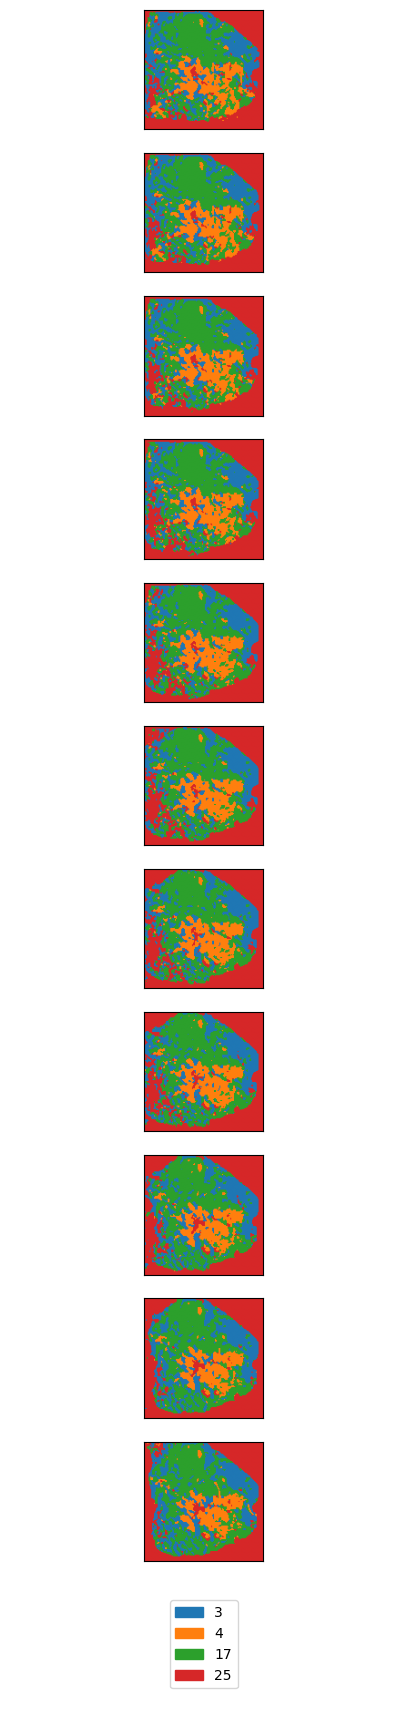

In [50]:
vis_utils.display_clusters(volume, horizontal=False)